In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import sympy as sp
from scipy.signal import savgol_filter

(200, 3600)


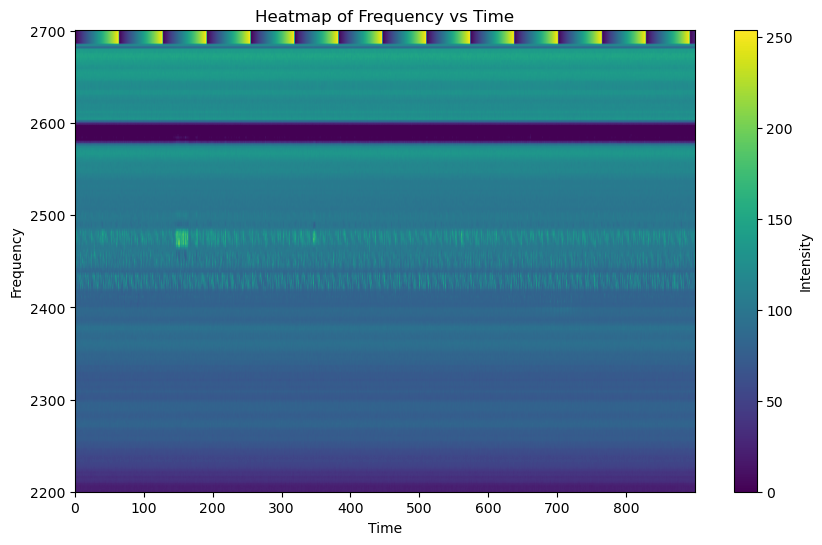

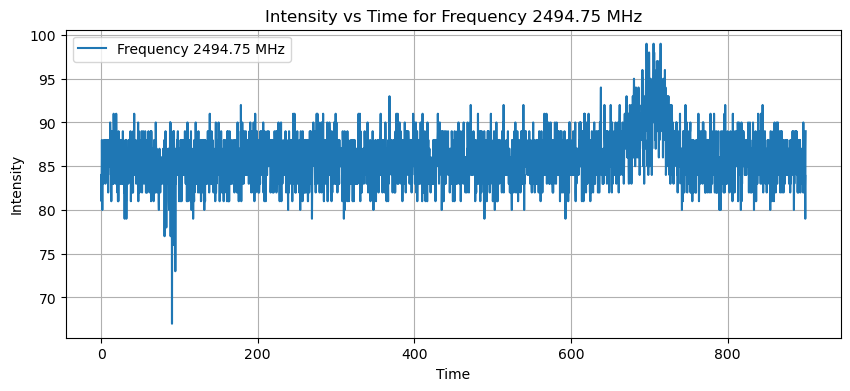

In [2]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load the .fits file
file_path = "sat_interest_25/ETH_20250108_041502_01.fit"  # Replace with your actual file path
hdul = fits.open(file_path)

# Display the header information (optional)
#print("Header information:")
#print(hdul[0].header)

# Access the data (assuming it's a 2D array with shape [frequency, time])
data = hdul[0].data
print(data.shape)

# Extract frequency and time from header (if provided)
# You may need to adjust these keys based on your file
#freq_axis = np.arange(data.shape[0])  # Dummy frequency axis if not provided
freq_axis = hdul[1].data[0][1] #* 10e5
#time_axis = np.arange(data.shape[1]) # Dummy time axis if not provided
time_axis = hdul[1].data[0][0]

# Close the file
hdul.close()

# Choose a specific frequency index (modify as needed)
frequency_index = 79  # Example: choose the 50th frequency; adjust as per your data
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined
intensity = data[frequency_index, :]

# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(data, aspect='auto', origin='lower', extent=[time_axis.min(), time_axis.max(), freq_axis.min(), freq_axis.max()], cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Heatmap of Frequency vs Time')
plt.show()

# Plot the intensity of the chosen frequency over time
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity , label=f'Frequency {chosen_frequency} MHz')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time for Frequency {chosen_frequency} MHz')
plt.legend()
plt.grid(True)
plt.show()

#print(time_axis.size) data[frequency_index, :]

#print(chosen_frequency)

Functions

In [3]:
def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B

Smoothing Data and fitting gaussian curve

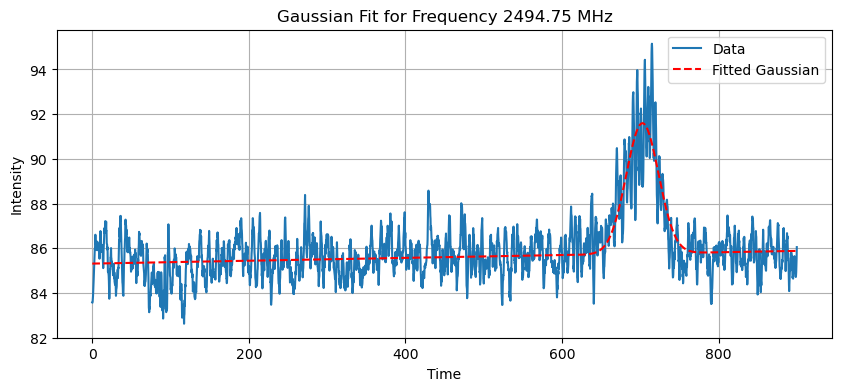

In [4]:
#Smoothing of Data using savglol filter
data_smoothed = savgol_filter(data[frequency_index, :], 21, polyorder=3)

gaussian_params, _ = curve_fit(
    gaussian,
    time_axis,
    data_smoothed,
    p0=[17.5, 700, 700, 0, 11],
    #p0=[17.5, 5720, 4640, 0, 11],
    maxfev=50000  # Increase maxfev to 5000
)

I, mu, sigma, A, B = gaussian_params

# Generate fitted values for plotting
fitted_gaussian_linear = gaussian(time_axis, I, mu, sigma, A, B)
fitted_gaussian = gaussian(time_axis, I, mu, sigma, 0, 0)

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
#plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, data_smoothed, label='Data')
plt.plot(time_axis, fitted_gaussian_linear, label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} MHz')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
intensity_no_linear = data_smoothed - A*time_axis - B
intensity_noGauss = intensity_no_linear/fitted_gaussian

defining relevant time period, fitting cos function

2494.75
0.12016933881150416
[3.94610697e-01 4.57457217e-03 1.35701473e+02]


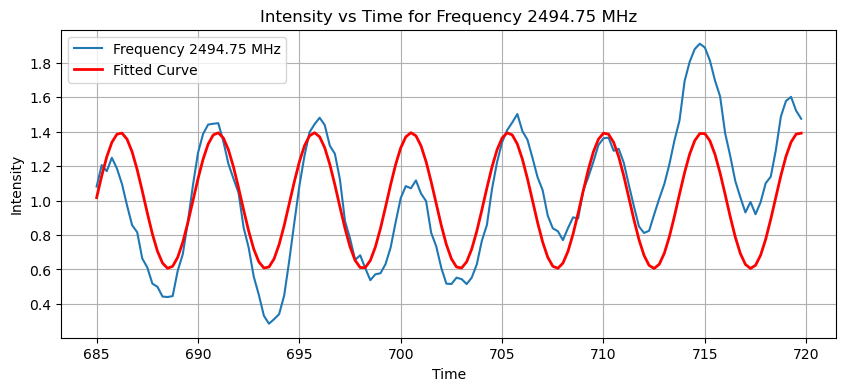

In [10]:
rel_time_start = 685 * 4
rel_time_stop = 720 * 4
intensity_values_rel_smooth = intensity_noGauss[rel_time_start:rel_time_stop]
time_axis_rel = time_axis[rel_time_start:rel_time_stop]

c = 299792458 # speed of light in m/s
B = 5.49 # length of Baseline in meters
lam = c/(chosen_frequency*1e6) # wavelength in meters

print(chosen_frequency)
print(lam)
#print(time_axis_rel)

# Define the theoretical fit function
def theoretical_fit(x, S, omega, phi):
    return (1 + S * np.cos( 2 * np.pi *B * omega * x / lam + phi)) #2* np.pi *

# Initial guesses for S, omega, and phi
initial_guess = [0.8, 0.005, 50]

# Set bounds for S, omega, and phi
lower_bounds = [0, 0, 0, -np.pi]  # Lower bound for S, omega, and phi
upper_bounds = [100, 3, 0.1, np.pi]  # Upper bound for S, omega, and phi

# Curve fitting with bounds
params, covariance = curve_fit(
    theoretical_fit,
    time_axis_rel,
    intensity_values_rel_smooth,
    p0=initial_guess,
    #bounds=(lower_bounds, upper_bounds),
    maxfev=50000
)

print(params)

# Extract the fitted parameters
S_fit, omega_fit, phi_fit = params

# Generate fitted curve
fitted_curve = theoretical_fit(time_axis_rel, S_fit, omega_fit, phi_fit)



# Plot the intensity of the chosen frequency over time
plt.figure(figsize=(10, 4))
plt.plot(time_axis_rel, intensity_values_rel_smooth, label=f'Frequency {chosen_frequency} MHz')
plt.plot(time_axis_rel, fitted_curve, label='Fitted Curve', linewidth=2, color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time for Frequency {chosen_frequency} MHz')
plt.legend()
plt.grid(True)
plt.show()

calculating Sat height

In [7]:
import sympy as sp

print(0.0043 / 0.0034)

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians

#omega_fit = 0.0048

# Define the equation_fit
equation = r**3 + R*r**2 - (G * M ) / omega_fit**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")

1.2647058823529413
Solution 1: -4339582.85669573 + 0.e-16*I
Solution 2: -4153728.15610483 - 0.e-16*I
Solution 3: 2122311.01280056 + 0.e-16*I


GLOBALSTAR M091:
  Rise:       2025-01-08 06:27:25 UTC+1
  Culminate:  2025-01-08 06:27:36 UTC+1, altitude: 2308.95 km
  Set:        2025-01-08 06:27:48 UTC+1

GLOBALSTAR M082:
  Rise:       2025-01-08 05:23:38 UTC+1
  Culminate:  2025-01-08 05:28:34 UTC+1, altitude: 1420.87 km
  Set:        2025-01-08 05:33:32 UTC+1